In [1]:
from fastai.vision import *
import matplotlib.pyplot as plt 

## Pixel Similarity

A straightforward approach might be to find an 'average' for each number.  Each of these 'averages' can then be compared with an unseen number and we can predict that the unseen number will be the one that it is most similar to.  We can use the training data to calculate the averages.  To determine the similarity we could compare each pixel and sum the differences to find a similarity value and simply selecting the number with the smallest value to be our prediction.

### Let's explore the dataset

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[PosixPath('/home/calum/.fastai/data/mnist_png/training'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing'),
 PosixPath('/home/calum/.fastai/data/mnist_png/models')]

In [14]:
train = (path/'training').ls()
sorted(train)

[PosixPath('/home/calum/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/9')]

In [73]:
ones = (path/'training'/'1').ls()
print("Total count:",  len(ones))
ones[:5]

Total count: 6742


[PosixPath('/home/calum/.fastai/data/mnist_png/training/1/58501.png'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/1/49008.png'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/1/15835.png'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/1/33368.png'),
 PosixPath('/home/calum/.fastai/data/mnist_png/training/1/2970.png')]

#### Open an example 1

torch.Size([1, 28, 28])

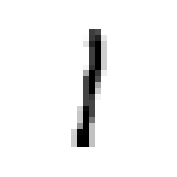

In [68]:
one = ones[0]
one = open_image(one, convert_mode='L') # mode is only 1 channel (i.e. is greyscale)
one.show(cmap='binary') # shows image in greyscale
one.shape

In [42]:
# This is just to demonstrate each image is made up of pixels with values from 0 to 1\
df = pd.DataFrame(image2np(img.data)[3:25,3:24])
df.style.set_properties(**{'font-size':'4pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.760784,0.705882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015686,0.768627,0.862745,0.105882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109804,0.862745,0.996078,0.192157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.756863,0.996078,0.192157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.756863,0.996078,0.192157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.756863,0.996078,0.192157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043137,0.800000,0.996078,0.192157,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.345098,0.996078,0.796078,0.062745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.733333,0.996078,0.701961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Calculate an average
These averaged digits are called <u>centroids</u> and are calculated by stacking all examples of a digit on top of one another, then taking the average value for each pixel

In [43]:
one_tensors = [open_image(o, convert_mode='L').data for o in ones]
len(one_tensors)

6742

In [44]:
stacked_ones = torch.stack(one_tensors)
stacked_ones.shape

torch.Size([6742, 1, 28, 28])

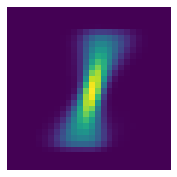

In [46]:
avg = stacked_ones.mean(0)
Image(avg).show()

This is the centroid for the digit 1, the average 1 in our data set.  

### Doing this for all digits

In [59]:
digit_tensors = [[open_image(d, convert_mode='L').data for d in digit.ls()] 
                 for digit in sorted(train)]

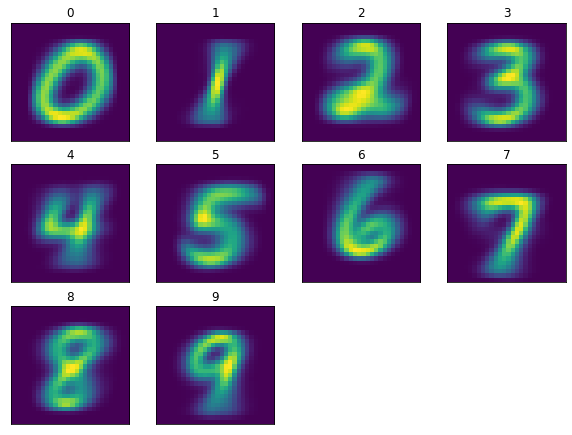

In [116]:
fig = plt.figure(figsize=(10, 10)) 
centroid = {}

for digit in range(10):
    centroid[digit] = torch.stack(digit_tensors[digit]).mean(0)
    ax = fig.add_subplot(4, 4, digit+1, xticks=[], yticks=[])
    ax.imshow(centroid[digit].squeeze())
    ax.set_title(str(digit))

### Calculating similarity score
First lets start with our first example of the digit one.  We will check it's score against the average 9 and the average 1.

There are many ways you could calculate this score, the most obvious might just be to take the mean of the absolute differences of each value.  Another commonly used method is RMSE or root mean squared error.  Let's investiagate the effects of using each method.  Are there any others?

In [117]:
sim_one = (one.data - centroid[1]).abs().mean()
sim_nine = (one.data - centroid[9]).abs().mean()
sim_one, sim_nine

(tensor(0.0541), tensor(0.1257))

The similarity score for our one to the average one appears to be smaller than the similarity score for an average nine.  This is because we're calculating the differences.  So this does make sense, but perhaps it should be called difference or error.

We can use pytorch's functional library to calculate these errors.  It's under the namespace 'F'.

In [118]:
F.l1_loss(one.data, centroid[1]), F.l1_loss(one.data, centroid[9])

(tensor(0.0541), tensor(0.1257))

In [119]:
F.mse_loss(one.data, centroid[1]), F.mse_loss(one.data, centroid[9])

(tensor(0.0175), tensor(0.0596))

### Evaluating against the validation set

In [124]:
err = F.mse_loss

In [125]:
valid = sorted((path/'testing').ls())
valid

[PosixPath('/home/calum/.fastai/data/mnist_png/testing/0'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/1'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/2'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/3'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/4'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/5'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/6'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/7'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/8'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/9')]

In [128]:
correct = 0

for target in range(10):
    for img in valid[target].ls():
        digit = open_image(img, convert_mode='L')
        _, pred = min([(err(digit.data, centroid[c]), c) for c in range(10)])
        if pred == target:
            correct += 1

### Accuracy

In [129]:
correct / 10000

0.8203